In [50]:
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [51]:
data_path = "../data/BPI_Challenge_2017.gzip"

# Event of interest: what to predict
event_of_interest = "A_Cancelled"  # O_Accepted

df_bpi= pd.read_parquet("../data/BPI_Challenge_2017.gzip")
df_bpi.rename(inplace=True, columns={"time:timestamp": "time", "case:concept:name": "case", "concept:name": "event"})
df_bpi["time"] = pd.to_datetime(df_bpi["time"], errors='coerce')


In [52]:
# Group data by case_id and get start and end events
start_events = df_bpi.groupby('case')['event'].first()
end_events = df_bpi.groupby('case')['event'].last()

# Count occurrences of start and end events
start_event_counts = Counter(start_events)
end_event_counts = Counter(end_events)

# Combine results into a DataFrame
results = pd.DataFrame({
    'Start_Event_Count': pd.Series(start_event_counts),
    'End_Event_Count': pd.Series(end_event_counts)
}).fillna(0).astype(int)

# Display the results
print(results)
# We conclude that only O_Cancelled, W_Call after offers, W_Call incomplete files, W_validate_application
# Remove other traces makes the process more uniform. 

# This is what is done in the "filter_log" function below

                            Start_Event_Count  End_Event_Count
A_Create Application                    31509                0
A_Denied                                    0                1
O_Cancelled                                 0             4436
O_Returned                                  0                1
O_Sent (mail and online)                    0               15
O_Sent (online only)                        0                8
W_Assess potential fraud                    0              102
W_Call after offers                         0             9457
W_Call incomplete files                     0             4676
W_Complete application                      0              144
W_Personal Loan collection                  0                2
W_Shortened completion                      0                5
W_Validate application                      0            12662


In [53]:
def filter_log(df):
    """..."""
    df = filter_out_uncommon_end_event_traces(df)
    # Potentially add more log filterings here

    return df

def filter_out_uncommon_end_event_traces(df):
    """..."""
    accepted_end_events = {'O_Cancelled', 'W_Call after offers', 'W_Call incomplete files', 'W_Validate application'}
    # Find the last event (end_event) for each case_id
    end_events = df.groupby('case')['event'].last()
    # Filter case_ids where the end_event is in the accepted list
    filtered_case_ids = end_events[end_events.isin(accepted_end_events)].index
    # Filter out the cases which are wanted
    filtered_df = df[df.case.isin(filtered_case_ids)]
    
    return filtered_df


def make_prefixes(df):
    """
    For each case in the DataFrame, create a 'prefix' column that is a growing list of events,
    and a 'total_time' column that represents the elapsed time in seconds since the first event
    in that case.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame must contain at least columns: ['case', 'event', 'time'].
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with 'prefix' (list of events so far) and 'total_time' (float - total seconds from first event).
    """
    df = df.copy()
    df['prefix'] = None
    df['total_time_prefix'] = None

    grouped = df.groupby('case')

    # Add a progress bar to show progress through the cases
    for case_id, group in tqdm(grouped, desc="Creating prefixes", total=len(grouped)):
        prefix_list = []
        first_time = None
        for idx, row in group.iterrows():
            prefix_list.append(row['event'])
            if first_time is None:
                first_time = row['time']
            total_seconds = (row['time'] - first_time).total_seconds()
            df.at[idx, 'prefix'] = prefix_list.copy()
            df.at[idx, 'total_time_prefix'] = total_seconds

    # Convert prefixes to lists (if necessary)
    df['prefix'] = df['prefix'].apply(lambda x: list(x) if isinstance(x, list) else x)
    
    # Optional: Drop last row as per original code
    df = df[:-1]

    return df


def add_case_traces_and_cancel_info(df, event_of_interest):
    """
    Adds columns related to case traces and A_Cancelled occurrences.
    This function:
    - Computes prefix length.
    - Computes full case traces.
    - Maps case traces to df.
    - Checks if 'A_Cancelled' has occurred in the prefix and in the entire case.
    """
    df = df.copy()
    print("Computing prefix lengths and case traces...")
    
    df['prefix_length'] = df['prefix'].apply(len)
    case_traces = df.groupby('case')['event'].apply(list)
    df['case_trace'] = df['case'].map(case_traces)

    print("Checking for A_Cancelled occurrences...")
    df['event_of_interest_is_in_prefix'] = df['prefix'].apply(lambda x: x.count(event_of_interest))
    df['event_of_interest_occured'] = df['case_trace'].apply(lambda x: x.count(event_of_interest))
    df = df[(df['event_of_interest_is_in_prefix'] != 1)] # Remove rows where A_Cancelled has already happened

    return df


def index_encoding(df):
    """
    Expand the prefix column into multiple columns (one for each event in the prefix).
    """
    print("Performing index encoding...")
    df = df.copy().reset_index(drop=True)
    max_length = df['prefix'].apply(len).max()
    event_cols = [f'event_{i+1}' for i in range(max_length)]

    expanded_prefix = pd.DataFrame(df['prefix'].tolist(), columns=event_cols, index=df.index)
    df = pd.concat([df, expanded_prefix], axis=1)

    return df


def frequency_encoding(df, prefix_col='prefix'):
    """
    Perform frequency encoding within the 'prefix' column.
    Each unique event becomes a column, and the values represent the frequency 
    of that event occurring in the prefix.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the 'prefix' and 'event' columns.
        prefix_col (str): Column containing the prefix data (lists of events).
        event_col (str): Column containing all unique events for reference.

    Returns:
        pd.DataFrame: DataFrame with new frequency-encoded columns.
    """
    print("Performing frequency encoding...")
    df = df.copy()
    # Extract all unique events
    unique_events = df["event"].unique()
    # Initialize columns for each unique event and calculate frequency in each prefix
    for event in unique_events:
        df[f'{event}_freq'] = df[prefix_col].apply(lambda prefix: prefix.count(event))

    return df


def frequency_encoding_opt(df, prefix_col='prefix', event_col='event'):
    df = df.copy()
    unique_events = df[event_col].unique()
    def count_events(prefix):
        event_counts = Counter(prefix)
        return [event_counts.get(event, 0) for event in unique_events]
    frequency_matrix = df[prefix_col].apply(count_events).tolist()
    freq_df = pd.DataFrame(frequency_matrix, columns=[f'freq_{event}' for event in unique_events])
    df = pd.concat([df, freq_df], axis=1)
    return df


def create_final_datasets(df):
    """
    Create final X (features) and Y (target) datasets.
    """
    print("Creating final X and Y datasets...")
    df = df.copy()

    # Perform train-test split
    df_train, df_test = split_data(df)

    # Remove unnecessary columns -> Change depending on new feature choices
    remove_these_cols = [
        'Action', 'org:resource', 'EventOrigin', 'EventID',
        'lifecycle:transition', 'case:LoanGoal', 'case:ApplicationType',
        'case:RequestedAmount', 'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
        'case', 'event', 'time', 'MonthlyCost', 'Selected', 'OfferID', 
        'FirstWithdrawalAmount', 'Accepted', 'CreditScore', 'NumberOfTerms'
    ]
    df_train = df_train.drop(remove_these_cols, axis=1)
    df_test = df_test.drop(remove_these_cols, axis=1)

    df_train = convert_int64_to_int8_or_int16(df_train)
    df_test = convert_int64_to_int8_or_int16(df_test)
    df_train = convert_columns_to_float(df_train)
    df_test = convert_columns_to_float(df_test)

    X_train = df_train.drop(columns=['event_of_interest_occured'], axis=1,).copy()
    X_test = df_test.drop(columns=['event_of_interest_occured'], axis=1,).copy()

    y_train = df_train[['event_of_interest_occured']].copy()
    y_test = df_test[['event_of_interest_occured']].copy()
    
    return X_train, y_train, X_test, y_test


def split_data(df, train_proportion=0.8):
    """
    Create a train-test split with the given train proportion. Furthermore, we want to filter 
    the train set to not contain traces which have time overlap with the traces in the test set
    """
    print("Doing the train-test split...")
    # Split dataset into train test with "train_proportion"
    lst_case = list(df['case'].unique())
    train_index = round(len(lst_case)*train_proportion)
    df_train_unfiltered = df[df['case'].isin(lst_case[:train_index])]
    df_test = df[df['case'].isin(lst_case[train_index:])]

    # Make sure that there is no time overlap between the train and test data
    max_time_train = df_test['time'].min()
    # Get the last event (row) for each case
    last_rows = df_train_unfiltered.groupby('case', as_index=False).tail(1)
    # Identify cases where the last event time is greater than max_time_train
    cases_to_exclude = last_rows.loc[last_rows['time'] > max_time_train, 'case']
    # Exclude these cases and reset index
    df_train = df_train_unfiltered[~df_train_unfiltered['case'].isin(cases_to_exclude)].reset_index(drop=True)

    train_percentage = (100*len(df_train.index)) / (len(df_train.index) + len(df_test.index))
    test_percentage = (100*len(df_test.index)) / (len(df_train.index) + len(df_test.index))
    print(f"After filtering train-test split {train_percentage}% train data and {test_percentage}% test data")

    return df_train, df_test


def compute_features(df):
    """
    Computes the features that we deem important for the prediction of the eventually follows relation with the
    event of interest. 
    1. Binary indicating the presence of A_Validating in prefix
    2. Total time in prefix
    3. Prefix length
    4. Average time per event in prefix
    5. ...
    Feature idea: last_resource, last_..., requested_amount 
    The last... features can just be obtained by keeping this column, because for each prefix automatically last value is stored. 
    """
    # 1. Binary indicating the presence of A_Validating in prefix
    df['a_validating_occurs'] = df['prefix'].apply(lambda lst: int("A_Validating" in lst) if isinstance(lst, list) else 0)  # --> bit strange because by default in frequency encoding
    # 2. This total prefix time already exists -> no further code necessary here
    # 3. This prefix length already exists -> no further code necessary here
    # 4. Average time per event in prefix must be computed by dividing total prefix time by number of events in prefix
    df["prefix_average_time"] = df["total_time_prefix"] / df["prefix_length"]
    return df


def convert_int64_to_int8_or_int16(dataframe):
    int64_cols = dataframe.select_dtypes(include=['int64']).columns
    for col in int64_cols:
        col_min = dataframe[col].min()
        col_max = dataframe[col].max()
        if col_min >= -128 and col_max <= 127:
            dataframe[col] = dataframe[col].astype('int8')
            print(f"Converted column '{col}' to int8.")
        elif col_min >= -32768 and col_max <= 32767:
            dataframe[col] = dataframe[col].astype('int16')
            print(f"Converted column '{col}' to int16.")
        else:
            print(f"Skipped column '{col}': no big downcast was done int64 was kept.")
    return dataframe


def convert_columns_to_float(dataframe):
    dataframe['total_time_prefix'] = dataframe['total_time_prefix'].astype(float)
    dataframe['prefix_average_time'] = dataframe['prefix_average_time'].astype(float)
    return dataframe


def pipeline(df, event_of_interest):
    """
    Full pipeline:
    1. Create prefixes.
    2. Add case trace and cancel info.
    3. Compute all necessary features for prediction task
    4. Perform index encoding.
    5. Prepare final X and Y datasets.
    """
    print("Starting pipeline...")
    df = filter_log(df)  # --> filter out incomplete cases (unfinished, not from beginning); other filtering maybe outliers
    df = make_prefixes(df)
    df = add_case_traces_and_cancel_info(df, event_of_interest)
    df = compute_features(df)
    # df = index_encoding(df)
    df = frequency_encoding(df)
    X_train, y_train, X_test, y_test = create_final_datasets(df)
    print("Pipeline completed.")

    return X_train, y_train, X_test, y_test


In [54]:
X_train, y_train, X_test, y_test = pipeline(df_bpi, event_of_interest)

Starting pipeline...


Creating prefixes: 100%|██████████| 31231/31231 [02:21<00:00, 219.96it/s]


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...
Performing frequency encoding...
Creating final X and Y datasets...
Doing the train-test split...
After filtering train-test split 78.65268227473744% train data and 21.34731772526255% test data
Converted column 'prefix_length' to int16.
Converted column 'event_of_interest_occured' to int8.
Converted column 'a_validating_occurs' to int8.
Converted column 'A_Create Application_freq' to int8.
Converted column 'A_Submitted_freq' to int8.
Converted column 'W_Handle leads_freq' to int8.
Converted column 'W_Complete application_freq' to int8.
Converted column 'A_Concept_freq' to int8.
Converted column 'A_Accepted_freq' to int8.
Converted column 'O_Create Offer_freq' to int8.
Converted column 'O_Created_freq' to int8.
Converted column 'O_Sent (mail and online)_freq' to int8.
Converted column 'W_Call after offers_freq' to int8.
Converted column 'A_Complete_freq' to int8.
Converted column 'W_Validate application_

In [69]:
df_bpi[df_bpi['OfferedAmount'].notna()]

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
9,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,2016-01-02 11:29:03.994000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,None
50,Created,User_38,O_Create Offer,Offer,Offer_1669071500,complete,2016-01-02 11:02:38.994000+00:00,Home improvement,New credit,Application_1691306052,10000.0,500.0,33.0,False,200.00,False,0.0,6000.0,None
79,Created,User_19,O_Create Offer,Offer,Offer_1209840642,complete,2016-01-02 11:05:15.942000+00:00,Home improvement,New credit,Application_428409768,15000.0,15000.0,120.0,True,158.98,False,0.0,15000.0,None
87,Created,User_19,O_Create Offer,Offer,Offer_997411923,complete,2016-01-02 11:25:44.202000+00:00,Home improvement,New credit,Application_428409768,15000.0,15000.0,120.0,True,158.98,True,1059.0,15000.0,None
135,Created,User_19,O_Create Offer,Offer,Offer_1319158006,complete,2016-01-04 17:19:15.892000+00:00,Car,New credit,Application_1746793196,5000.0,3726.0,96.0,False,198.65,False,0.0,15700.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202122,Created,User_84,O_Create Offer,Offer,Offer_682062790,complete,2017-01-02 13:33:03.922000+00:00,Existing loan takeover,New credit,Application_2103458006,15000.0,2000.0,120.0,True,154.11,False,0.0,15000.0,None
1202124,Created,User_84,O_Create Offer,Offer,Offer_1395096354,complete,2017-01-02 13:34:11.626000+00:00,Existing loan takeover,New credit,Application_2103458006,15000.0,0.0,127.0,True,150.00,False,0.0,15000.0,None
1202148,Created,User_84,O_Create Offer,Offer,Offer_1445809476,complete,2017-01-02 19:07:57.476000+00:00,Home improvement,New credit,Application_59622033,10000.0,10000.0,120.0,True,106.46,True,854.0,10000.0,None
1202202,Created,User_84,O_Create Offer,Offer,Offer_1734870628,complete,2017-01-04 19:30:29.845000+00:00,Car,New credit,Application_303923658,30000.0,0.0,77.0,True,450.00,True,996.0,30000.0,None


In [73]:
df_bpi['OfferedAmount'] = df_bpi.groupby('case')['OfferedAmount'].ffill()

In [74]:
df_bpi

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,20000.0,None
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,20000.0,None
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,20000.0,None
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,20000.0,Offer_1580299144


In [75]:
# Example dataframe
data = {
    'case': ['A','A','A','A','A','B','B','B','B'],
    'event': ['O_Created Offer', 'something', 'something_else', 'O_Created Offer', 'another_event',
              'O_Created Offer', 'something', 'O_Created Offer', 'final_event'],
    'OfferAmount': [100, None, None, 200, None, 50, None, 300, None]
}

df = pd.DataFrame(data)

# Sort by case and by the order of events if you have a timestamp or a known sequence.
# If your data is already in chronological order, this may not be necessary.
# Here we'll assume the given order is correct.

# For each case, forward fill the OfferAmount
df['OfferAmount'] = df.groupby('case')['OfferAmount'].ffill()

print(df)

  case            event  OfferAmount
0    A  O_Created Offer        100.0
1    A        something        100.0
2    A   something_else        100.0
3    A  O_Created Offer        200.0
4    A    another_event        200.0
5    B  O_Created Offer         50.0
6    B        something         50.0
7    B  O_Created Offer        300.0
8    B      final_event        300.0


In [70]:
df_bpi

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,Offer_1580299144


In [56]:
def make_naive_baseline(y_train, y_test):
    a_canceled_proportion = float((y_train.sum() / len(y_train)).iloc[0])
    y_naive_baseline = [1 if random.random() < a_canceled_proportion else 0 for _ in range(len(y_test))]
    return y_naive_baseline
y_naive = make_naive_baseline(y_train, y_test)

In [57]:
i = 0
for naive, test in zip(y_naive, y_test['event_of_interest_occured']):
    if naive == test:
        i+=1
i /len(y_naive)
        

0.6754864914711193

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7295
ROC AUC: 0.6841
Confusion Matrix:
[[153265  35220]
 [ 27851  16813]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83    188485
           1       0.32      0.38      0.35     44664

    accuracy                           0.73    233149
   macro avg       0.58      0.59      0.59    233149
weighted avg       0.75      0.73      0.74    233149



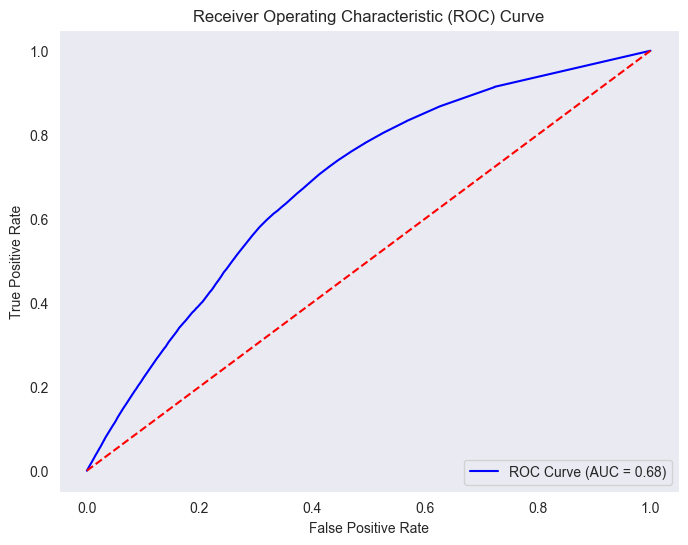

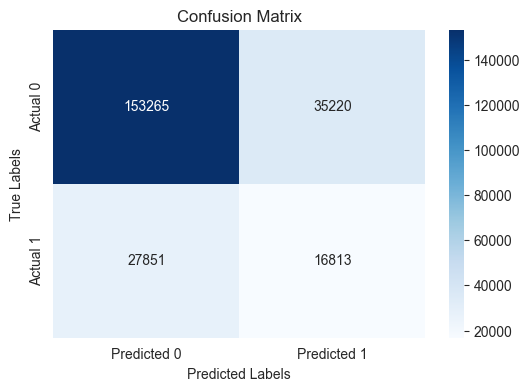

Top 10 Features:
total_time_prefix               0.331231
prefix_average_time             0.300981
W_Validate application_freq     0.065917
W_Call after offers_freq        0.046271
a_validating_occurs             0.039233
prefix_length                   0.036179
A_Validating_freq               0.030445
O_Returned_freq                 0.028401
W_Complete application_freq     0.026626
W_Call incomplete files_freq    0.017445
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_21148\480318542.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


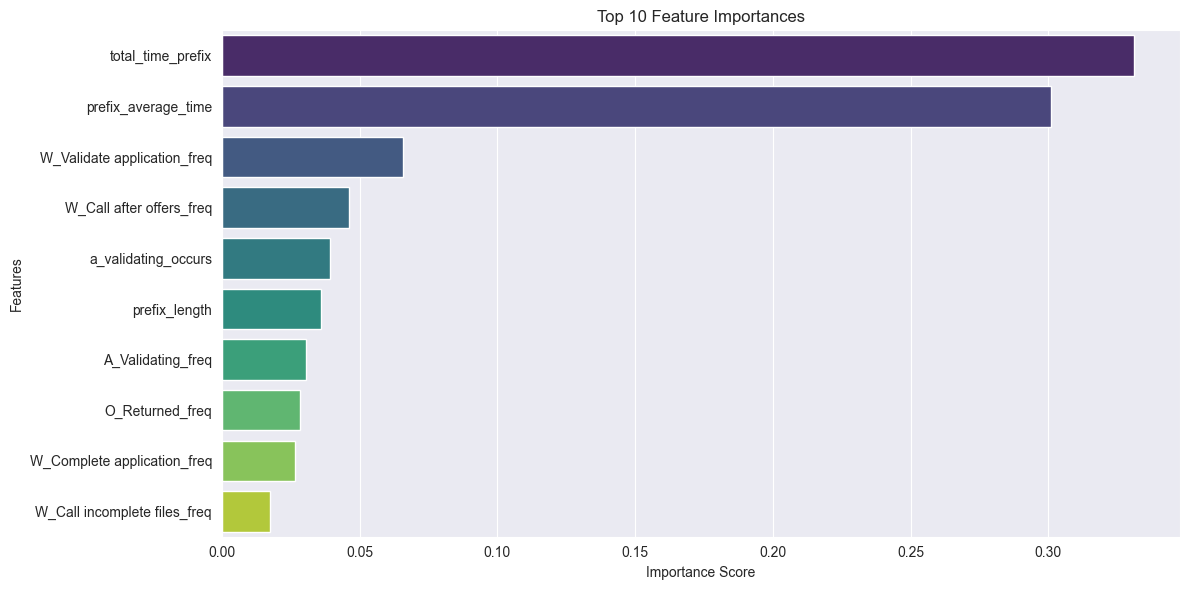

In [58]:
def train_random_forest_model(X_train, y_train):
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    # Train the model
    rf.fit(X_train, y_train)
    return rf


def obtain_test_predictions(X_test, rf):
    # Make predictions
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    return y_pred, y_pred_proba


def plot_evaluation_insights(y_test, y_pred, y_pred_proba):
    # -----------------------------------
    # Model Evaluation
    # -----------------------------------

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


def random_forest_feature_importance(X_train, rf):
    # -----------------------------------
    # Feature Importance
    # -----------------------------------

    # Extract feature importances
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Display top 10 features
    top_n = 10
    top_features = feature_importances_sorted.head(top_n)
    print(f"Top {top_n} Features:")
    print(top_features)

    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


rf = train_random_forest_model(X_train, y_train)
y_pred, y_pred_proba = obtain_test_predictions(X_test, rf)
plot_evaluation_insights(y_test, y_pred, y_pred_proba)
random_forest_feature_importance(X_train, rf)


Epoch 1/15 | Train Loss: 45.6425 | Val Loss: 54.6800
Model saved to ../trained_models/neural_network/best_model.pth
Epoch 2/15 | Train Loss: 42.8323 | Val Loss: 52.4309
Model saved to ../trained_models/neural_network/best_model.pth
Epoch 3/15 | Train Loss: 37.9566 | Val Loss: 51.9408
Model saved to ../trained_models/neural_network/best_model.pth
Epoch 4/15 | Train Loss: 33.9680 | Val Loss: 25.0876
Model saved to ../trained_models/neural_network/best_model.pth
Epoch 5/15 | Train Loss: 32.0734 | Val Loss: 51.3198
Epoch 6/15 | Train Loss: 26.3735 | Val Loss: 21.8426
Model saved to ../trained_models/neural_network/best_model.pth
Epoch 7/15 | Train Loss: 30.9332 | Val Loss: 24.5881
Epoch 8/15 | Train Loss: 5.0285 | Val Loss: 0.6633
Model saved to ../trained_models/neural_network/best_model.pth
Epoch 9/15 | Train Loss: 0.6650 | Val Loss: 0.6639
Epoch 10/15 | Train Loss: 0.6651 | Val Loss: 0.6636
Epoch 11/15 | Train Loss: 0.6650 | Val Loss: 0.6635
Epoch 12/15 | Train Loss: 0.6650 | Val Loss: 

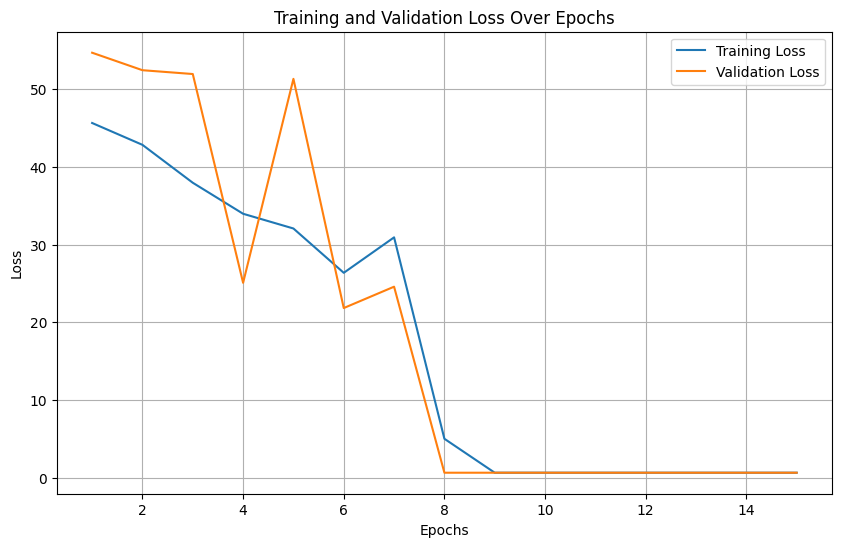

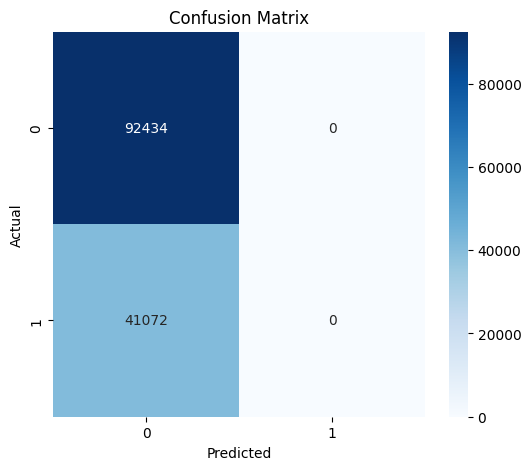

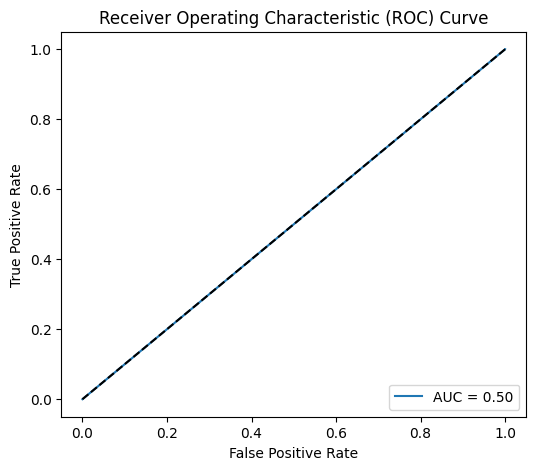

Accuracy: 0.6924
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Model saved to ../trained_models/neural_network/final_model.pth


c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\Advanced_PM_Group14\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Assuming X_train, X_test, y_train, y_test are already defined as pandas DataFrames/Series
# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  #.unsqueeze(1)  # Ensure it's a column tensor
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)  #.unsqueeze(1)

# Create TensorDatasets
train_dataset_full = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split the training dataset into training and validation sets
validation_split = 0.15
train_size = int((1 - validation_split) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network Architecture
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)  # Output layer for binary classification

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.sigmoid(self.output(x))  # Sigmoid activation for binary output
        return x

input_dim = X_train_tensor.shape[1]
model = BinaryClassificationModel(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Optional: Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training procedure with validation and early stopping
def network_training_procedure(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10, patience=7):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Step the scheduler
        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            # Optionally, save the best model here
            save_model(model, path='../trained_models/neural_network/best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# Evaluate model
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)
    with torch.no_grad():
        predictions = []
        actuals = []
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    # Convert probabilities to binary predictions
    prediction_probabilities = np.array(predictions).flatten()
    predictions_binary = (prediction_probabilities >= 0.5).astype(int)
    actuals = np.array(actuals).flatten()
    return predictions_binary, prediction_probabilities, actuals

# Save the final model
def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')

# Load the model (for inference)
def load_model(path, input_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BinaryClassificationModel(input_dim)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Define a function to plot evaluation insights
def plot_evaluation_insights(actuals, predictions, prediction_probabilities):
    from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
    import seaborn as sns

    # Confusion Matrix
    cm = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(actuals, prediction_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Print Evaluation Metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions)
    recall = recall_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Train the model with validation and early stopping
model = network_training_procedure(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,      # Increased epochs for better training
    patience=7          # Early stopping patience
)

# Evaluate the model on the test set
predictions, prediction_probabilities, actuals = evaluate_model(model, test_loader)

# Plot evaluation insights
plot_evaluation_insights(actuals, predictions, prediction_probabilities)

# Save the final model
save_model(model, path='../trained_models/neural_network/final_model.pth')

# Example of loading the model for inference
# loaded_model = load_model('../trained_models/neural_network/final_model.pth', input_dim)


In [ ]:
save_model(model)

In [60]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# X_train = torch.tensor(X_train.values, dtype=torch.float32)
# X_test = torch.tensor(X_test.values, dtype=torch.float32)
# y_train = torch.tensor(y_train.values, dtype=torch.float32)  #.unsqueeze(1)  # Ensure it's a column tensor
# y_test = torch.tensor(y_test.values, dtype=torch.float32)  #.unsqueeze(1)

# # Create TensorDatasets
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# # Create DataLoaders
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

# # Simple Neural Network Architecture
# class BinaryClassificationModel(nn.Module):
#     def __init__(self, input_dim):
#         super(BinaryClassificationModel, self).__init__()
#         self.layer1 = nn.Linear(input_dim, 64)
#         self.layer2 = nn.Linear(64, 32)
#         self.output = nn.Linear(32, 1)  # Output layer for binary classification

#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = torch.sigmoid(self.output(x))  # Sigmoid activation for binary output
#         return x

# input_dim = X_train.shape[1]
# model = BinaryClassificationModel(input_dim)

# # Define loss function and optimizer for training
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss --> because we make binary prediction
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training procedure
# def network_training_procedure(model, criterion, optimizer, train_loader, num_epochs=5):
#     num_epochs = num_epochs
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch_X, batch_y in train_loader:
#             batch_X, batch_y = batch_X.to(device), batch_y.to(device)

#             optimizer.zero_grad()
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    
#     return model

# # Evaluate model
# def evaluate_model(model, test_loader):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.eval()  # makes sure weights freeze and you can run inputs through model without just to obtain outputs
#     with torch.no_grad():
#         predictions = []
#         actuals = []
#         for batch_X, batch_y in test_loader:
#             batch_X = batch_X.to(device)
#             outputs = model(batch_X)
#             predictions.extend(outputs.cpu().numpy())
#             actuals.extend(batch_y.cpu().numpy())

#     # Convert probabilities to binary predictions
#     prediction_probabilities = np.array(predictions)
#     predictions = np.array(predictions) >= 0.5
#     actuals = np.array(actuals)
#     return predictions, prediction_probabilities, actuals

# # Save the final model
# def save_model(model):
#     # Save the model
#     torch.save(model.state_dict(), '../trained_models/neural_network/test_model.pth')

# # Load the model (for inference)
# def load_model(path):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BinaryClassificationModel(input_dim)
#     model.load_state_dict(torch.load('../trained_models/neural_network/test_model.pth'))
#     model.to(device)
#     model.eval()


# model = network_training_procedure(model, criterion, optimizer, train_loader, num_epochs=15)
# predictions, prediction_probabilities, actuals = evaluate_model(model, test_loader)

# plot_evaluation_insights(actuals, predictions, prediction_probabilities)